# Score Plots

In [1]:
from jaxgeometry.manifolds import Euclidean, nSphere
from jaxgeometry.setup import dts, jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from jaxgeometry.statistics.score_matching import model_loader
from scores import models

2023-10-02 15:43:24.280462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Define Manifolds

## R2

In [2]:
R2 = Euclidean(N=2)
jstoch.Brownian_coords(R2)
jstat.diffusion_mean(R2)

using M.Exp for Logarithm


In [3]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))
t = 0.5

### DSM

In [ ]:
file_path = 'scores/R2/dsm/'
state = model_loader.load_model(file_path)

In [ ]:
layers = [50, 100, 100, 50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=R2.dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=R2.dim, r = max(N_dim//2,1))(x))

In [ ]:
model = s1_model
rng_key = jax.random.PRNGKey(2712)
def grady_log_model(x,y,t):
    
    return model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log_model(x,y,t):
    
    grad_val = grady_log_model(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_model(x, y, t)))

In [ ]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

In [ ]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere
#Plotting
# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y: R2.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$',
            fontsize=20)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
fig.savefig('Figures/r2_angle.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

### Plotting the Norm Difference in $x$

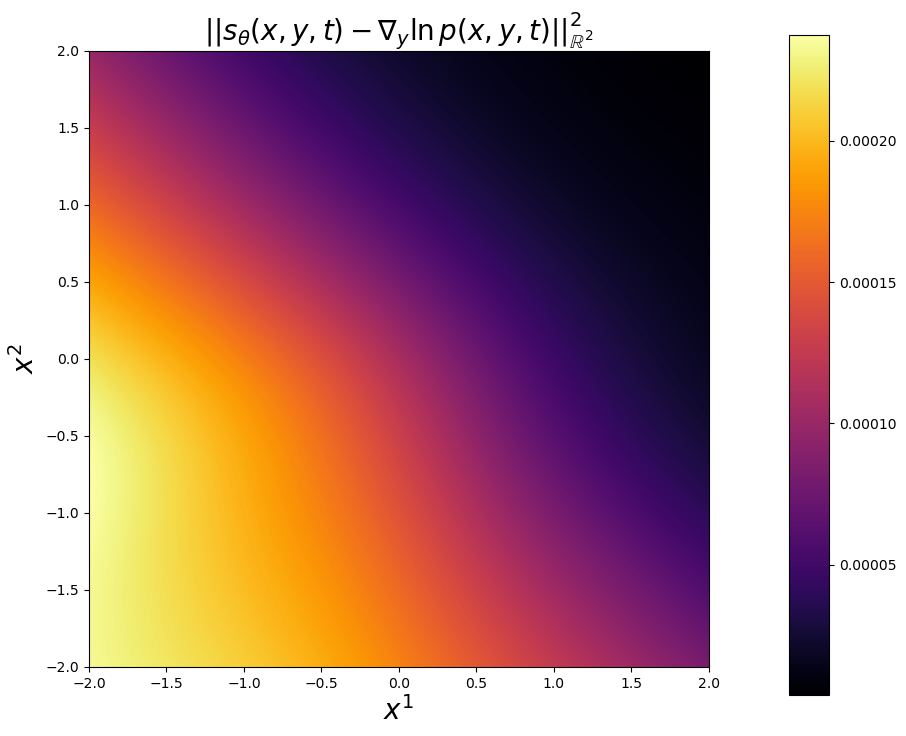

In [9]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values
intervals = 1000

min_x = -2.0
max_x = 2.0
min_t = 1e-8
max_t = 1.0

x1 = jnp.linspace(min_x, max_x, intervals)
x2 = jnp.linspace(min_x, max_x, intervals)
t1 = jnp.linspace(min_t, max_t, intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda y: R2.grady_log_hk(x0, (y, jnp.zeros(1)), t)[0]
numerical_grad = lambda y: grady_log_model(x0, (y, jnp.zeros(1)), t)
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heat_map, cmap=mpl.cm.inferno, interpolation='nearest', aspect='auto',
          extent=[min_x,max_x,min_x,max_x])
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$||s_{\theta}(x,y,t)-\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}^{2}$', fontsize=20)
ax.set_ylim((min_x,max_x))
ax.set_xlim((min_x,max_x))
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
cax = plt.axes([1.0, 0.075, 0.05, 0.825])
fig.colorbar(m, ax=ax, cax=cax)
ax.autoscale(False)
fig.savefig('Figures/r2_norm.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

### Estimate Diffusion Mean

In [10]:
def s1_grad(x,y,t):
    
    return model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def s2_grad(x,y,t):
    
    ggrad = jacfwdx(lambda y: model.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

diffusion_mean.initialize(R2, s1_model=s1_grad, s2_model = s2_grad)

In [11]:
theta = jnp.linspace(0,2*jnp.pi, 100)

X_obs = (jnp.array([jnp.cos(theta), jnp.sin(theta)]).T, jnp.zeros(100))
x0 = (jnp.zeros(2), jnp.zeros(1))

In [12]:
mu_sm, T_sm, _, _ = R2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [13]:
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = R2.diffusion_mean(X_obs,num_steps=10, N=100)

Step 0 | T: 1.151140e+01 | T: ((Array([-0.1129039 ,  0.06268033], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.036830e+01 | T: ((Array([-0.10298775,  0.05283985], dtype=float32), Array(0.2199273, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.398618e+00 | T: ((Array([-0.09320924,  0.04328199], dtype=float32), Array(0.22974169, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.573577e+00 | T: ((Array([-0.08361933,  0.03413702], dtype=float32), Array(0.23940888, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.869215e+00 | T: ((Array([-0.07426544,  0.02553485], dtype=float32), Array(0.24890035, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 7.265666e+00 | T: ((Array([-0.06519061,  0.01759557], dtype=float32), Array(0.25819302, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.746462e+00 | T: ((Array([-0.05643305,  0.01041987], dtype=float32), Array(0.26726866, dtype=float32)), Array([0.], dt

In [14]:
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
T_bridge = jnp.stack(T_bridge)

In [15]:
mu_opt, T_opt = R2.mlxt_hk(X_obs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


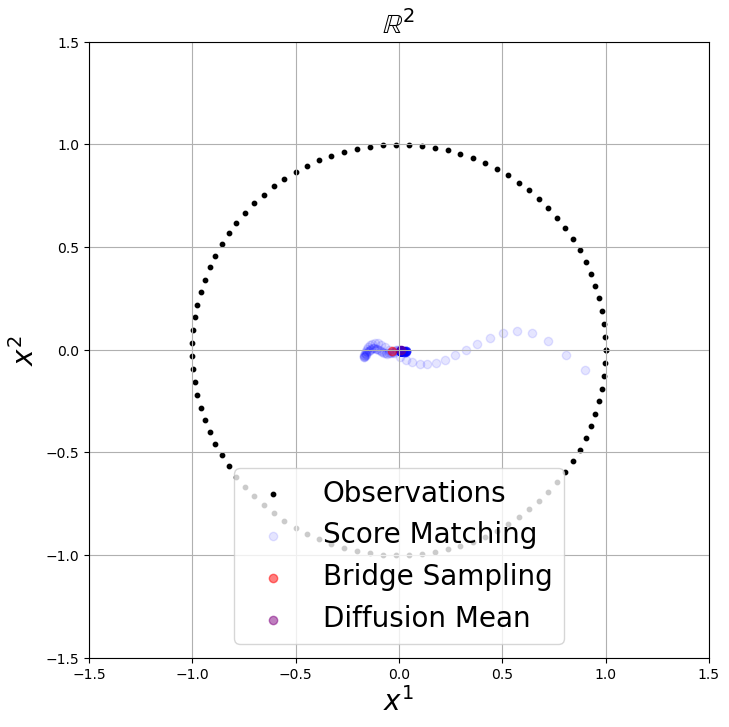

In [16]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu_sm[0][:,0], mu_sm[0][:,1], color='blue', label='Score Matching', alpha=.1)
ax.scatter(mu_bridgex[-1][0], mu_bridgex[-1][1], color='red', label=r'Bridge Sampling',alpha=.5)
ax.scatter(mu_opt[0][0], mu_opt[0][1], color='purple', label=r'Diffusion Mean',alpha=.5)
ax.set_title(r'$\mathbb{R}^{2}$', fontsize=20)
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_xestimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


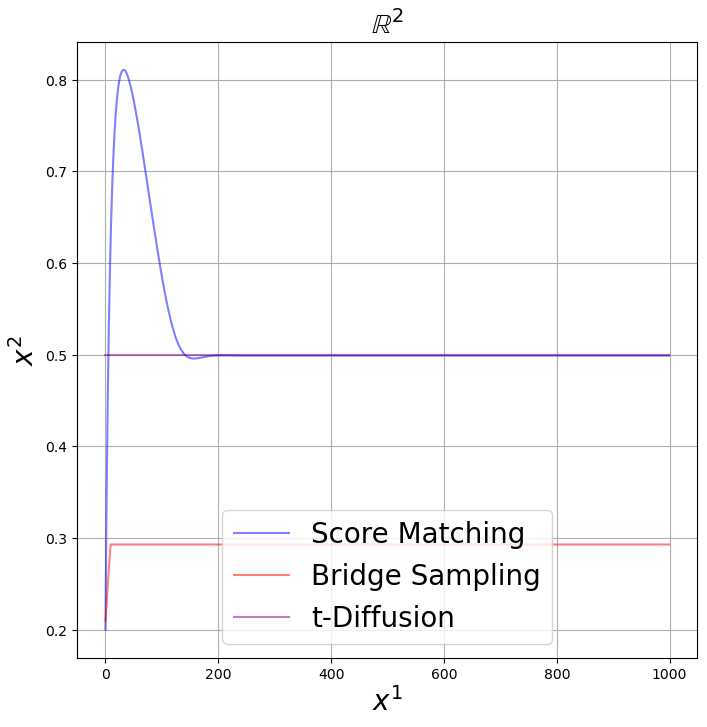

In [17]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(jnp.arange(0,len(T_sm),1), T_sm, color='blue', label='Score Matching', alpha=.5)
ax.plot(jnp.arange(0,len(T_sm),1), jnp.append(T_bridge, T_bridge[-1]*jnp.ones(len(T_sm)-len(T_bridge))), color='red', label=r'Bridge Sampling',alpha=.5)
ax.plot(jnp.arange(0,len(T_sm),1), T_opt*jnp.ones(len(T_sm)), color='purple', label=r't-Diffusion',alpha=.5)
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$\mathbb{R}^{2}$', fontsize=20)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_testimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

## S2

In [2]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)

x0 = S2.coords([0.]*2)
t = 0.5

using M.Exp for Logarithm


In [3]:
def get_coords(Fx):
    chart = S2.centered_chart(Fx)
    return (S2.invF((Fx,chart)),chart)

def to_TM(Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = S2.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(Fx,v):

    x = get_coords(Fx)

    return jnp.dot(S2.invJF((Fx,x[1])),v)

In [4]:
# Creating the theta and phi values.
N_points = 100
theta = jnp.pi/2
phi = jnp.linspace(0.0, jnp.pi*2, N_points)
X1_circle = jnp.sin(theta)*jnp.cos(phi)
X2_circle = jnp.sin(theta)*jnp.sin(phi)
X3_circle = jnp.cos(theta)*jnp.ones(N_points)
X_circle = jnp.concatenate((X1_circle.reshape(1,-1), X2_circle.reshape(1,-1), X3_circle.reshape(1,-1))).T
X_circle = X_circle[:-1]

X_obs = vmap(lambda x: get_coords(x))(X_circle)

### DSM

In [5]:
file_path = 'scores/S2/dsm/'
state = model_loader.load_model(file_path)

In [6]:
layers = [50, 100, 100, 50]#[50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))

In [7]:
model = s1_model
rng_key = jax.random.PRNGKey(2712)
def grady_log_model(x,y,t):
    
    return to_TMx(y[1], model.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log_model(x,y,t):
    
    grad_val = grady_log_model(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_model(x, y, t)))

In [8]:
#Source: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / jnp.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return jnp.arccos(jnp.clip(jnp.dot(v1_u, v2_u), -1.0, 1.0))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


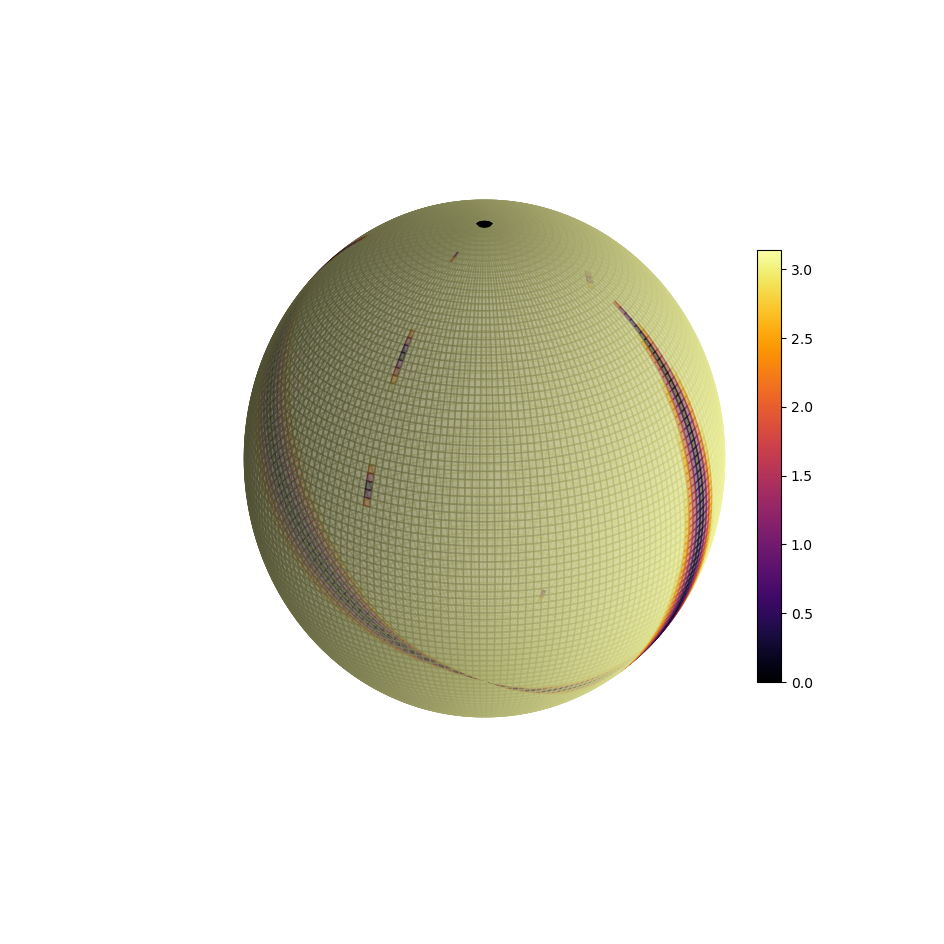

In [9]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

min_t = 0.1
max_t = 0.9

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
t1 = jnp.linspace(min_t, max_t, intervals+1)

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_heat = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_heat = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_heat = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, ntheta+1, nphi+1), 
                     X2_heat.reshape(1, ntheta+1, nphi+1), 
                     X3_heat.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

# Creating the coordinate grid for the unit sphere.
X1_vec = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_vec = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_vec = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, ntheta+1, nphi+1), 
                     X2_vec.reshape(1, ntheta+1, nphi+1), 
                     X3_vec.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

theoretical_grad = lambda y: S2.grady_log_hk(x0, get_coords(y), t)[0]
numerical_grad = lambda y: grady_log_model(x0, get_coords(y), t)
heat_map = vmap(lambda x2: vmap(lambda x1: angle_between(theoretical_grad(x1),
                                                         numerical_grad(x1)))(x2))(X_heat)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
#ax.set_xlabel(r'$x^{1}$')
#ax.set_ylabel(r'$x^{2}$')
#ax.set_zlabel(r'$x^{3}$')
#ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}^{t}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}^{t}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$')
ax.set_box_aspect([1,1,1])
ax.set_axis_off()
cax = plt.axes([0.75, 0.32, 0.02, 0.36])
fig.colorbar(m, ax=ax, cax=cax)
fig.savefig('Figures/s2_angle.eps', format='eps', pad_inches=0.1, bbox_inches='tight')

### Plotting the Norm Difference in $x$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


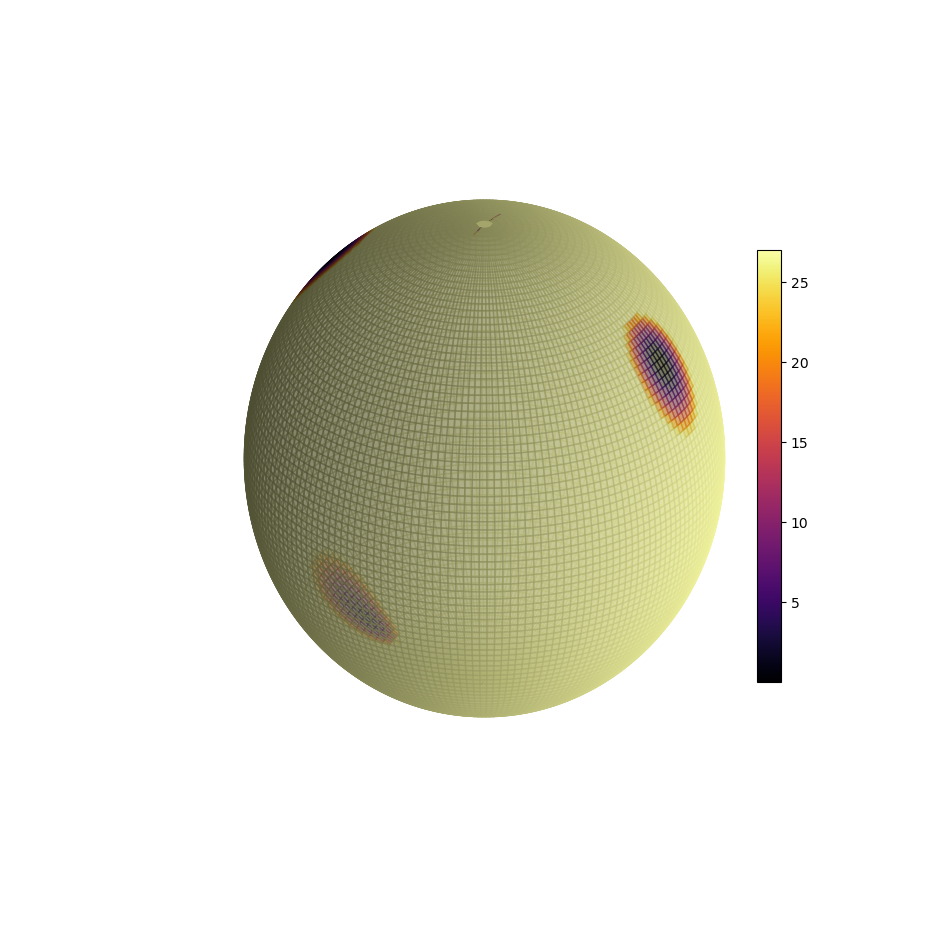

In [10]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

min_t = 0.1
max_t = 0.9

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
t1 = jnp.linspace(min_t, max_t, intervals+1)

# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_heat = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_heat = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_heat = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, ntheta+1, nphi+1), 
                     X2_heat.reshape(1, ntheta+1, nphi+1), 
                     X3_heat.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

# Creating the coordinate grid for the unit sphere.
X1_vec = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_vec = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_vec = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, ntheta+1, nphi+1), 
                     X2_vec.reshape(1, ntheta+1, nphi+1), 
                     X3_vec.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

theoretical_grad = lambda y: S2.grady_log_hk(x0, get_coords(y), t)[0]
numerical_grad = lambda y: grady_log_model(x0, get_coords(y), t)
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.linalg.norm(theoretical_grad(x1)-numerical_grad(x1))**2)(x2))(X_heat)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
#ax.set_xlabel(r'$x^{1}$')
#ax.set_ylabel(r'$x^{2}$')
#ax.set_zlabel(r'$x^{3}$')
#ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}^{t}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}^{t}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$')
ax.set_box_aspect([1,1,1])
ax.set_axis_off()
cax = plt.axes([0.75, 0.32, 0.02, 0.36])
fig.colorbar(m, ax=ax, cax=cax)
fig.savefig('Figures/s2_angle.eps', format='eps', pad_inches=0.1, bbox_inches='tight')

### Estimate Diffusion Mean

In [11]:
def s1_grad(x,y,t):
    
    return to_TMx(y[1], model.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def s2_grad(x,y,t):
    
    ggrad = jacfwdx(lambda y: model.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t))))(y)
    
    return ggrad

diffusion_mean.initialize(S2, s1_model=s1_grad, s2_model = s2_grad)

In [12]:
mu_sm, T_sm, _, _ = S2.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [13]:
# run once to compile
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = S2.diffusion_mean(X_obs,num_steps=2)
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = S2.diffusion_mean(X_obs,num_steps=30)

Step 0 | T: 2.964562e+01 | T: ((Array([-7.8998301e-09, -1.3229675e-08], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.20299248, -0.41298267,  0.8878284 ], dtype=float32))
Step 1 | T: 2.646328e+01 | T: ((Array([0.00964434, 0.00994943], dtype=float32), Array(0.21992983, dtype=float32)), Array([ 0.20299248, -0.41298267,  0.8878284 ], dtype=float32))
Final 1 | T: 2.646328e+01 | T: (Array([0.00964434, 0.00994943], dtype=float32), Array(0.21992983, dtype=float32))
CPU times: user 17 s, sys: 97.6 ms, total: 17.1 s
Wall time: 17 s
Step 0 | T: 2.964738e+01 | T: ((Array([-7.8998301e-09, -1.3229675e-08], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.20299248, -0.41298267,  0.8878284 ], dtype=float32))
Step 1 | T: 2.646542e+01 | T: ((Array([0.00964751, 0.00995129], dtype=float32), Array(0.21992987, dtype=float32)), Array([ 0.20299248, -0.41298267,  0.8878284 ], dtype=float32))
Step 2 | T: 2.385883e+01 | T: ((Array([0.01908812, 0.01991554], dtype=float32), Array(0.2297

In [15]:
mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
T_bridge = jnp.stack(T_bridge)

In [16]:
mu_bridgechart

(Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 Array([0., 0., 1.], dtype=float32),
 

In [20]:
# Creating the theta and phi values.
N_points = 100
theta = jnp.pi/2
phi = jnp.linspace(0.0, jnp.pi*2, N_points)
X1_circle = jnp.sin(theta)*jnp.cos(phi)
X2_circle = jnp.sin(theta)*jnp.sin(phi)
X3_circle = jnp.cos(theta)*jnp.ones(N_points)
X_circle = jnp.concatenate((X1_circle.reshape(1,-1), X2_circle.reshape(1,-1), X3_circle.reshape(1,-1))).T
X_circle = X_circle[:-1]

X_obs = vmap(lambda x: get_coords(x))(X_circle)

# run once to compile
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = S2.diffusion_mean(X_obs,num_steps=2)
# run MLE
%time (thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = S2.diffusion_mean(X_obs,num_steps=30)

mu_bridge, t_bridge, mu_chart = list(zip(*mu_bridge))
mu_bridge = (jnp.stack(mu_bridge), jnp.stack(mu_chart))
t_bridge = jnp.stack(t_bridge)

Step 0 | T: 2.856776e+01 | T: ((Array([-1.0282677e-09, -0.0000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32))
Step 1 | T: 2.561416e+01 | T: ((Array([0.00942783, 0.00989128], dtype=float32), Array(0.21993095, dtype=float32)), Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32))
Final 1 | T: 2.561416e+01 | T: (Array([0.00942783, 0.00989128], dtype=float32), Array(0.21993095, dtype=float32))
CPU times: user 321 ms, sys: 10.4 ms, total: 331 ms
Wall time: 328 ms
Step 0 | T: 2.856485e+01 | T: ((Array([-1.0282677e-09, -0.0000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32))
Step 1 | T: 2.562294e+01 | T: ((Array([0.00943339, 0.00989262], dtype=float32), Array(0.21993127, dtype=float32)), Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32))
Step 2 | T: 2.315116e+01 | T: ((Array([0.0182452, 0.0196371], dtype=float32), Array(0.22

In [21]:
mu_bridgechart

(Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32),
 Array([ 0.25586724, -0.08530934,  0.9629404 ], dtype=float32))

In [75]:
mu_opt, T_opt = RN.mlxt_hk(X_obs)

NameError: name 'RN' is not defined

In [ ]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_obs[0][:,0], X_obs[0][:,1], s=10, color='black', label='Observations')
#ax.scatter(mu_true_est[0][:,0], mu_true_est[0][:,1], s=20*t_true_est, color='orange', label=r'$\nabla_{y}\ln p(x,y,t)$')
ax.scatter(mu_sm[0][:,0], mu_sm[0][:,1], color='blue', label='Score Matching', alpha=.1)
ax.scatter(mu_bridgex[-1][0], mu_bridgex[-1][1], color='red', label=r'Bridge Sampling',alpha=.5)
ax.scatter(mu_opt[0][0], mu_opt[0][1], color='purple', label=r'Diffusion Mean',alpha=.5)
ax.set_title(r'$\mathbb{R}^{2}$', fontsize=20)
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_xestimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()

In [ ]:
# Creating the plot.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(jnp.arange(0,len(T_sm),1), T_sm, color='blue', label='Score Matching', alpha=.5)
ax.plot(jnp.arange(0,len(T_sm),1), jnp.append(T_bridge, T_bridge[-1]*jnp.ones(len(T_sm)-len(T_bridge))), color='red', label=r'Bridge Sampling',alpha=.5)
ax.plot(jnp.arange(0,len(T_sm),1), T_opt*jnp.ones(len(T_sm)), color='purple', label=r't-Diffusion',alpha=.5)
ax.set_xlabel(r'$x^{1}$', fontsize=20)
ax.set_ylabel(r'$x^{2}$', fontsize=20)
ax.set_title(r'$\mathbb{R}^{2}$', fontsize=20)
#ax.set_title(r'Diffusion Mean Estimates')
ax.legend(loc='lower center', fontsize=20)
ax.grid()
fig.savefig('Figures/r2_testimates.eps', format='eps', pad_inches=0.1, bbox_inches='tight')
#fig.tight_layout()